In [0]:
# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

In [0]:
!pip install -q wordcloud

In [0]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 98kB/s 
     |████████████████████████████████| 3.2MB 36.5MB/s 
     |████████████████████████████████| 491kB 25.5MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import string

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import glob
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#Por favor mover la carpeta que le comparto "evaluacion-semoralesco-master" a su unidad antes de ejecutar este bloque de código
#para asegurar que la ruta especificada en el próximo bloque es correcta
#importación de los contenidos presentes del drive para poder leer los datos a utilizar en el modelo
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.DataFrame(columns = ['type', 'text'])

In [0]:
#Verificar que una vez movida la carpeta a "Mi unidad" la ruta sí sea la correcta
import csv
sms = open("/content/drive/My Drive/evaluacion-semoralesco-master/datos/SMSSpamCollection.txt", "r")
csv_reader = csv.reader(sms, delimiter='\t')

In [0]:
#Lectura del archivo txt como dataframe
import sys
sms_data = []
sms_labels = []
for i in csv_reader:
  sms_labels.append(i[0])
  sms_data.append(i[1])
df['type'] = sms_labels
df['text'] = sms_data

In [0]:
df["type"].replace({"ham": "0", "spam": "1"}, inplace=True)
x = df['text']
y = df['type']

In [0]:
#Procesamiento del lenguaje natural
stemmer = SnowballStemmer("english")
def cleanText(message):      
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    return " ".join(words)    
X = list(map(cleanText, x))

In [21]:
#Bolsa de palabras
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
X.shape

(5572, 8098)

In [22]:
#Se visualiza la posición 0 del vector x, es decir 0 para ham y 1 para spam
X = X.toarray()
X[0]

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
#MRL
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = y, test_size = 0.3,random_state=101)
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#Matriz de condusión
confusion_matrix(y_test, y_pred)

array([[1443,    5],
       [  31,  193]])

In [24]:
#Puntaje de presición entre las pruebs y las predicciones
print(accuracy_score(y_test, y_pred))

0.9784688995215312


In [25]:
#Reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       0.97      0.86      0.91       224

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [0]:
##Clasificador con redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

In [27]:
#Estimación del número de capas óptimo para el modelo con redes neuronales
def grid_layers(capas):
    param = []
    for i in range(len(capas)):
        classifier = tf.keras.Sequential()
        classifier.add(layers.Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 8098))
        for j in range(capas[i]-1):
            classifier.add(layers.Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
        classifier.add(layers.Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
        classifier.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])
        classifier.fit(X_train, y_train, batch_size = 50, epochs = 30)
        y_pred = classifier.predict(X_test)
        y_pred = (y_pred > 0.5)
        cm = confusion_matrix(y_test, y_pred)
        param.append([classifier.summary(),cm,classifier.evaluate(X_test, y_test)])
    return param

layersx = [2,5,8]

resultado = grid_layers(layersx)

Epoch 1/30
78/78 [==============================] - 0s 5ms/step - loss: 0.3330 - accuracy: 0.8651
Epoch 2/30
78/78 [==============================] - 0s 5ms/step - loss: 0.1245 - accuracy: 0.9123
Epoch 3/30
78/78 [==============================] - 0s 5ms/step - loss: 0.0824 - accuracy: 0.9949
Epoch 4/30
78/78 [==============================] - 0s 5ms/step - loss: 0.0575 - accuracy: 0.9985
Epoch 5/30
78/78 [==============================] - 0s 5ms/step - loss: 0.0423 - accuracy: 1.0000
Epoch 6/30
78/78 [==============================] - 0s 5ms/step - loss: 0.0321 - accuracy: 1.0000
Epoch 7/30
78/78 [==============================] - 0s 5ms/step - loss: 0.0251 - accuracy: 1.0000
Epoch 8/30
78/78 [==============================] - 0s 5ms/step - loss: 0.0201 - accuracy: 1.0000
Epoch 9/30
78/78 [==============================] - 0s 5ms/step - loss: 0.0165 - accuracy: 1.0000
Epoch 10/30
78/78 [==============================] - 0s 5ms/step - loss: 0.0137 - accuracy: 1.0000
Epoch 11/30
78/78 [

In [28]:
resultado

[[None, array([[1448,    0],
         [  22,  202]]), [0.13519354164600372, 0.9868420958518982]],
 [None, array([[1444,    4],
         [  25,  199]]), [0.2640267312526703, 0.9826555252075195]],
 [None, array([[1439,    9],
         [  24,  200]]), [0.4601520895957947, 0.9802631735801697]]]

In [0]:
precision = [i[2][1] for i in resultado]

<BarContainer object of 3 artists>

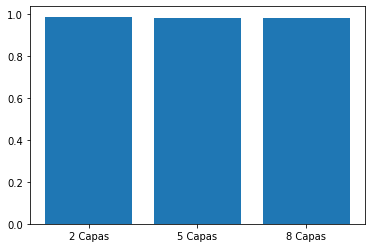

In [32]:
plt.bar(["2 Capas","5 Capas","8 Capas"],precision)

Aparentemente sin importar si se usan 2, 5 u 8 capas, el rendimiento es igual, por lo tanto se utilizarán 2 capas ya que representa menor costo computacional.

In [33]:
#Estimación del número de neuronas por capa óptimo
def grid_neurons(neuronas):
    param = []  
    for i in range(len(neuronas)):   
        classifier = tf.keras.Sequential()
        classifier.add(layers.Dense(units = neuronas[i], kernel_initializer = 'uniform', activation = 'relu', input_dim = 8098))
        classifier.add(layers.Dense(units = neuronas[i], kernel_initializer = 'uniform', activation = 'relu'))
        classifier.add(layers.Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
        classifier.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])
        classifier.fit(X_train, y_train, batch_size = 32, epochs = 30)
        y_pred = classifier.predict(X_test)
        y_pred = (y_pred > 0.5)
        cm = confusion_matrix(y_test, y_pred)
        param.append([classifier.summary(),cm,classifier.evaluate(X_test, y_test)])
    return param

neurons = [8,16,32,64]

resultado_neuronas = grid_neurons(neurons)

Epoch 1/30
122/122 [==============================] - 0s 4ms/step - loss: 0.2607 - accuracy: 0.8623
Epoch 2/30
122/122 [==============================] - 0s 4ms/step - loss: 0.0994 - accuracy: 0.9813
Epoch 3/30
122/122 [==============================] - 0s 4ms/step - loss: 0.0565 - accuracy: 0.9956
Epoch 4/30
122/122 [==============================] - 0s 4ms/step - loss: 0.0365 - accuracy: 0.9985
Epoch 5/30
122/122 [==============================] - 0s 4ms/step - loss: 0.0250 - accuracy: 0.9992
Epoch 6/30
122/122 [==============================] - 0s 4ms/step - loss: 0.0187 - accuracy: 0.9992
Epoch 7/30
122/122 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9995
Epoch 8/30
122/122 [==============================] - 0s 4ms/step - loss: 0.0104 - accuracy: 1.0000
Epoch 9/30
122/122 [==============================] - 0s 3ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 10/30
122/122 [==============================] - 0s 3ms/step - loss: 0.0067 - accuracy: 1.0000

In [34]:
resultado_neuronas

[[None, array([[1444,    4],
         [  22,  202]]), [0.15008953213691711, 0.9844497442245483]],
 [None, array([[1446,    2],
         [  18,  206]]), [0.16830842196941376, 0.9880383014678955]],
 [None, array([[1446,    2],
         [  21,  203]]), [0.1675224006175995, 0.9862440228462219]],
 [None, array([[1446,    2],
         [  18,  206]]), [0.19849823415279388, 0.9880383014678955]]]

In [35]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
def regresor_base(optimizer,activation):
    modelo = tf.keras.Sequential()
    modelo.add(layers.Dense(units = 8, kernel_initializer = 'uniform', activation = activation, input_dim = 8098))
    modelo.add(layers.Dropout(rate = 0.1))
    modelo.add(layers.Dense(units = 8, kernel_initializer = 'uniform', activation = activation))
    modelo.add(layers.Dropout(rate = 0.1))
    modelo.add(layers.Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    
    modelo.compile(optimizer = optimizer, loss = 'binary_crossentropy' ,metrics = ['acc'])
    
    return  modelo


regresor = KerasClassifier(build_fn = regresor_base)

parameters = {'batch_size': [5,10,20,50],
              'epochs': [20,40,60,100],
              'optimizer': ['adam'],
              'activation':['sigmoid','relu']              
             }

## Cross validation 
grid_search = GridSearchCV(estimator = regresor,
                           param_grid = parameters,
                           cv=2
                           )
grid_search = grid_search.fit(X_train, y_train)

Using TensorFlow backend.


Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 23/60
98/98 [==============================] - 0s 3ms/step - loss: 0.1514 - acc: 0.8677
Epoch 24/60
98/98 [==============================] - 0s 3ms/step - loss: 0.1450 - acc: 0.8677
Epoch 25/60
98/98 [==============================] - 0s 3ms/step - loss: 0.1359 - acc: 0.8708
Epoch 26/60
98/98 [==============================] - 0s 3ms/step - loss: 0.1260 - acc: 0.8856
Epoch 27/60
98/98 [==============================] - 0s 3ms/step - loss: 0.1215 - acc: 0.9031
Epoch 28/60
98/98 [==============================] - 0s 3ms/step - loss: 0.1128 - acc: 0.9426
Epoch 29/60
98/98 [==============================] - 0s 3ms/step - loss: 0.1077 - acc: 0.9800
Epoch 30/60
98/98 [==============================] - 0s 3ms/step - loss: 0.0999 - acc: 0.9892
Epoch 31/60
98/98 [==============================] - 0s 3ms/step - loss: 0.0944 - acc: 0.9928
Epoch 32/60
98/98 [==============================] - 0s 3ms/step - loss: 0.0902 - acc: 0.9944

In [36]:
neurons

[8, 16, 32, 64]

In [0]:
loss = [i[-1][0] for i in resultado_neuronas]
precission = [i[-1][1] for i in resultado_neuronas]

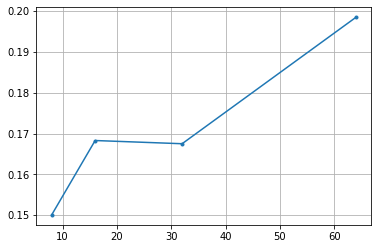

In [38]:
plt.plot(neurons, loss , '.-')
plt.grid()

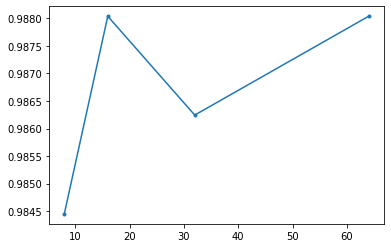

In [39]:
plt.plot(neurons, precission , '.-')

Como puede apreciarse en las gráficas, la pérdida mínima se da con aproximadamente 7 neuronas y la presición máxima con aproximadamente 17 neuronas

In [47]:
## Modelo final con hyper parametros ajustados
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
classifier = Sequential()
classifier.add(layers.Dense(units = 16, kernel_initializer = 'uniform', activation = 'sigmoid', input_dim = 8098))
classifier.add(layers.Dense(units = 16, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.add(layers.Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
classifier.fit(X_train, y_train, batch_size = 5, epochs = 100,callbacks=[es, rlr])

y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

AttributeError: ignored

In [43]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1443,    5],
       [  31,  193]])

In [0]:
classifier.evaluate(y_test, y_pred)

Parece ser que se obtienen mejores resultados aplicando una red neuronal al modelo, sin embargo habría que considerar si vale la pena la inversión y el tiempo para la mejora que representa.